## Подготовка сессии

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import cv2
import glob
import json
import shutil

import pandas as pd 
import numpy as np
import segmentation_models_pytorch as smp

from time import sleep
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [ ]:
def correct_file_names(folder):
    for name in os.listdir(folder):
        full_name = os.path.join(folder, name)
        os.rename(full_name, full_name.replace(' ', ''))

correct_file_names('eye_train')

In [ ]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """
    def __init__(self, data_folder: str, transform = None, train=True):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self.train = train
        self._image_files = glob.glob(f"{data_folder}/*.png")
        self._json_files = glob.glob(f"{data_folder}/*.geojson")

        if self.train:
            def get_name(path):
                return path.split('/')[-1].split('.')[0]
            
            # filter images without geojson files
            json_names = [get_name(path) for path in self._json_files]
            self._image_files = [path for path in self._image_files if get_name(path) in json_names]

        print(f'Total images: {len(self._image_files)}')
    
    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)

        # !!! GRAY or COLOR !!!
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = np.array(image / 255, dtype=np.float32)
        return image
    
    @staticmethod
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask
    
    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)

    def __getitem__(self, idx: int) -> dict:
        image_path = self._image_files[idx]
        image = self.read_image(image_path)
        sample = {'image': image, 'img_name': image_path.split('/')[-1]}

        if self.train:
            json_path = image_path.replace("png", "geojson")
            mask = self.read_layout(json_path, image.shape[:2])
            sample['mask'] = mask

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)

In [ ]:
# Инициализируем датасет
dataset = EyeDataset('eye_train')

Total images: 652


In [ ]:
# Original shape = (1232, 1624, 3) - всех кроме одного

IMG_SIZE = (1248, 1632)  # for Unet models need to be x32

train_list = [
    A.PadIfNeeded(*IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    ToTensorV2(transpose_mask=True),
]

eval_list = [
    A.PadIfNeeded(*IMG_SIZE),
    ToTensorV2(transpose_mask=True)
]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}

In [ ]:
test_size=0.025
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=17)

print(f"Разбиение на train/val : {len(train_indices)}/{len(val_indices)}")

Разбиение на train/val : 635/17


In [ ]:
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
val_dataset = DatasetPart(dataset, val_indices, transform=transforms['test'])

In [ ]:
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

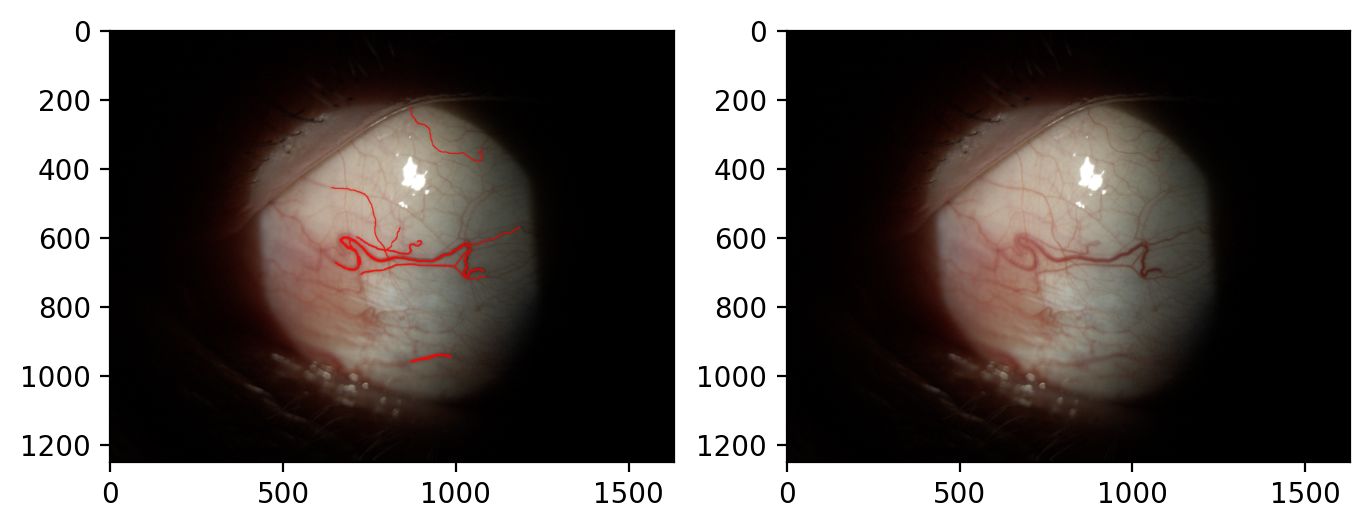

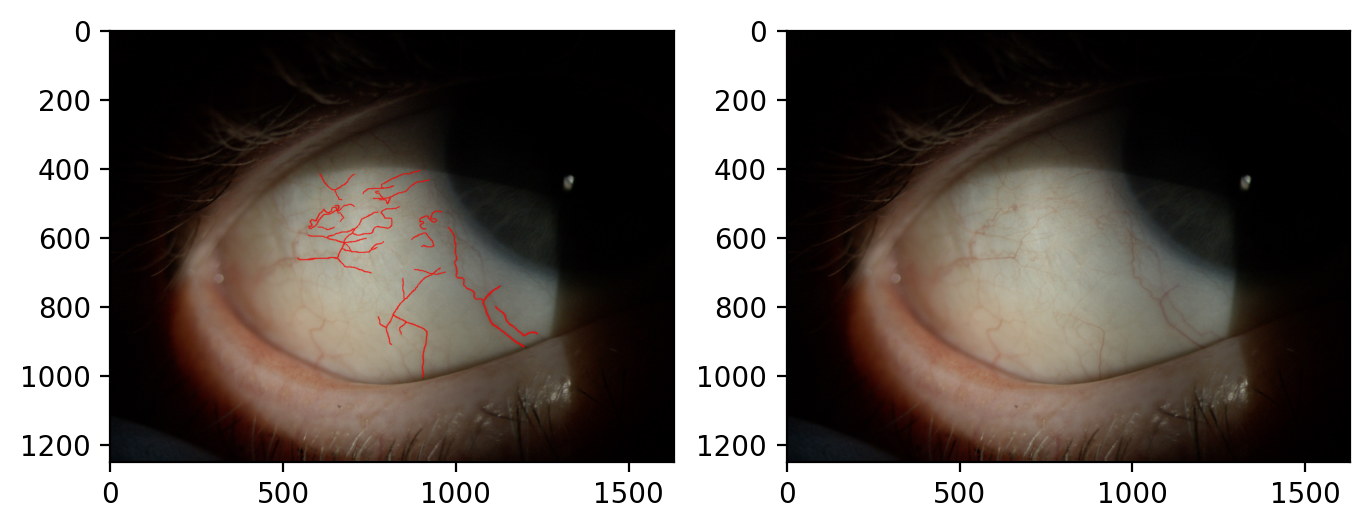

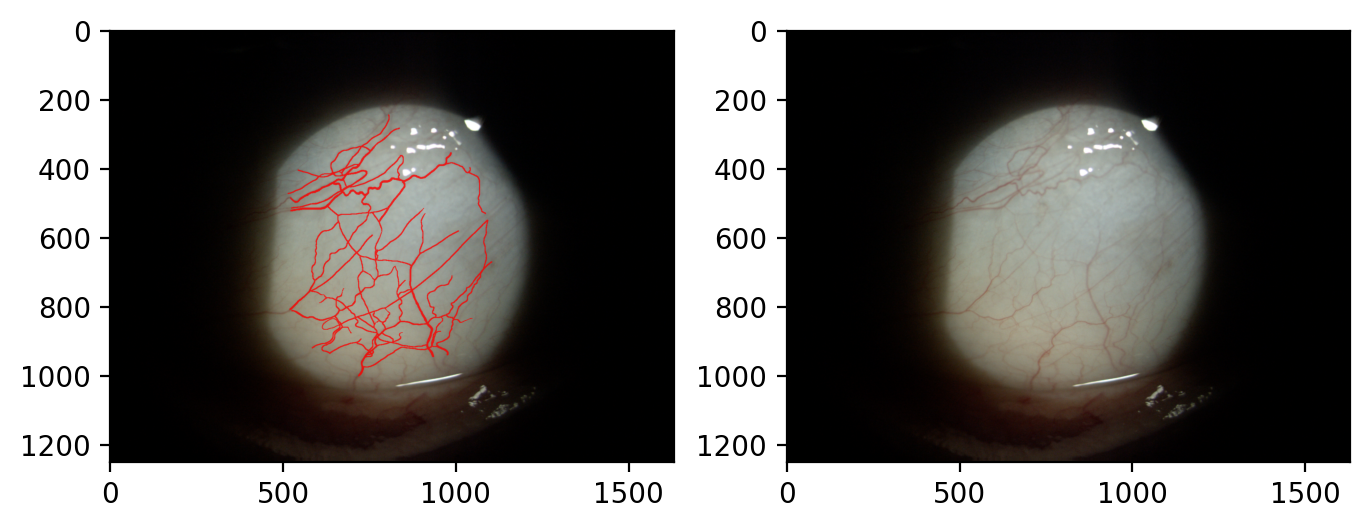

In [ ]:
# Посмотрим на картинки из датасета
n = 3

for i in range(n):
#     i = 2
    sample = train_dataset[i]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=200)

    image, mask = sample["image"], sample["mask"]

    image = torch.clip(image, 0.0, 1.0)

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), ~mask.type(torch.bool), colors='red')
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[0].imshow(image_with_mask)

    image = np.moveaxis(image.cpu().numpy(), 0, -1)
    axs[1].imshow(image)
    plt.show()

## Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title):
    plt.figure()
    plt.plot(train_history, label='train', zorder=1)
    
    steps = list(range(0, len(train_history), int(len(train_history) / len(val_history))))
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.title('{}'.format(title))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Класс тренировщика модели

In [ ]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict


class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device
        self.metric_functions = metric_functions
        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        for _ in tqdm(iter(int, 1)):
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        for _ in tqdm(iter(int, 1)):
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int, folder_to_save: str,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        if not os.path.exists(folder_to_save):
            os.mkdir(folder_to_save)

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        try:
            for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
                train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

                torch.save(model.state_dict(), os.path.join(folder_to_save, f'epoch_{self.epoch_number}.pth'))

                with torch.no_grad():
                    save_metrics(train_metrics, postfix='_train')

                    if val_loader is not None:
                        val_metrics = self.evaluate(val_loader)
                        save_metrics(val_metrics, postfix='_val')

                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                
                clear_output()
                print(f'Epoch: {self.epoch_number}\n')
                plot_history(summary['loss_train'], summary['loss_val'], 'loss')
                plot_history(summary['soft_dice_train'], summary['soft_dice_val'], 'soft_dice')
                plot_history(summary['precision_train'], summary['precision_val'], 'precision')
                plot_history(summary['recall_train'], summary['recall_val'], 'recall')
                plot_history(summary['F1_train'], summary['F1_val'], 'F1')

                self.epoch_number += 1
        except KeyboardInterrupt:
            pass

        return summary

# Метрики

In [ ]:
class Jacc:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions + targets) - intersection
        return intersection / (union + self.epsilon)

class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return (numerator + self.epsilon) / (denominator + self.epsilon)

class Recall:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return (numerator + self.epsilon) / (denominator + self.epsilon)

class Precision:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return (numerator + self.epsilon) / (denominator + self.epsilon)

class F1:
    def __init__(self, epsilon=1e-8, threshold=0.5):
        self.epsilon = epsilon
        self.threshold = threshold

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        predictions = predictions > self.threshold
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return (numerator + self.epsilon) / (denominator + self.epsilon)


def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    precision = Precision()
    jacc = Jacc()
    f1 = F1()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_precision(pred, target):
        return precision(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])
    
    def exp_jacc(pred, target):
        return jacc(torch.exp(pred[:, 1:]), target[:, 1:])
    
    def exp_f1(pred, target):
        return f1(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('soft_dice', exp_dice),
            ('precision', exp_precision),
            ('recall', exp_recall),
            ('jacc', exp_jacc),
            ('F1', exp_f1)]

## Модель

In [ ]:
def make_criterion():
    # criterion = Jacc()
    criterion = SoftDice()

    def exp_criterion(pred, target):
        return 1 - criterion(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_criterion

In [ ]:
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

folder_to_save = 'vgg16'
model = smp.Unet('vgg16', activation='logsoftmax', classes=2).to(device)

# load trained weights if need
# model_path = os.path.join(drive_path, folder_to_save, 'epoch_3.pth')
model_path = os.path.join(folder_to_save, 'epoch_15.pth')
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

cuda


Epoch: 11



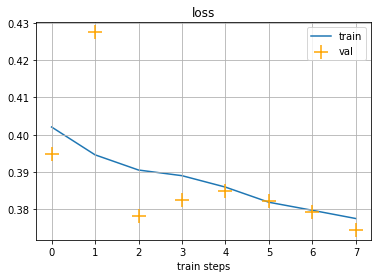

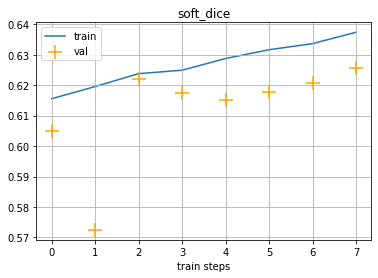

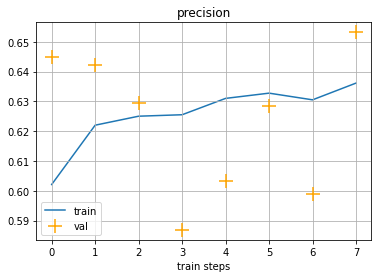

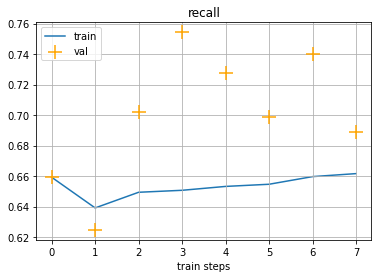

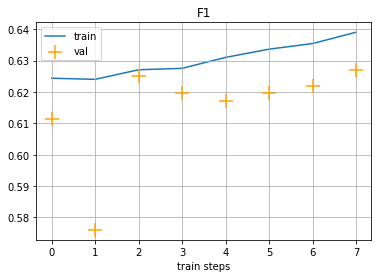

0it [00:00, ?it/s]

In [ ]:
# trainer = UnetTrainer(model, optimizer, criterion, device, metric_functions=make_metrics(), epoch_number=12)
# summary = trainer.fit(
#     train_loader, num_epochs=20,
#     folder_to_save=folder_to_save,
#     val_loader=val_loader, update_every_n_batches = 4 // batch_size  # a * b = 4
# )

Epoch: 12



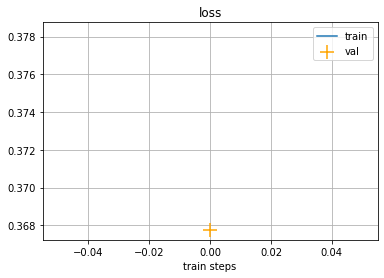

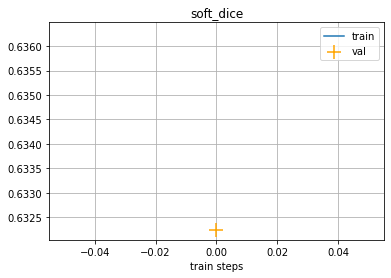

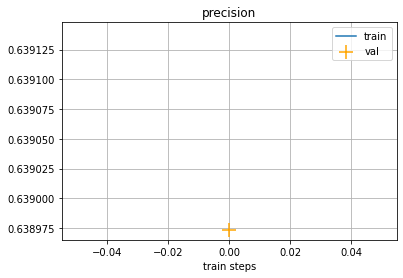

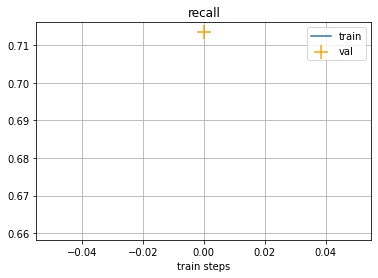

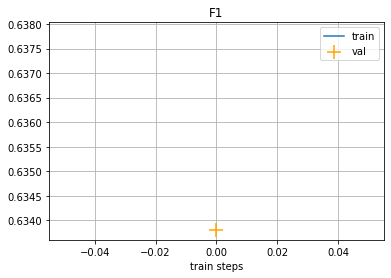

0it [00:00, ?it/s]

In [ ]:
trainer = UnetTrainer(model, optimizer, criterion, device, metric_functions=make_metrics(), epoch_number=12)
summary = trainer.fit(
    train_loader, num_epochs=20,
    folder_to_save=folder_to_save,
    val_loader=val_loader, update_every_n_batches = 4 // batch_size  # a * b = 4
)

Epoch: 15



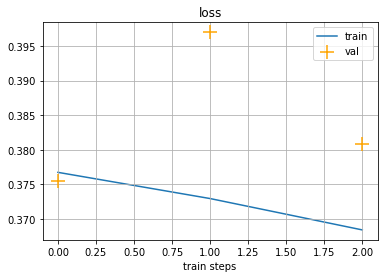

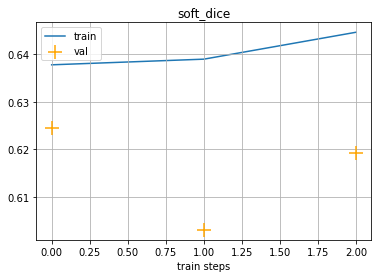

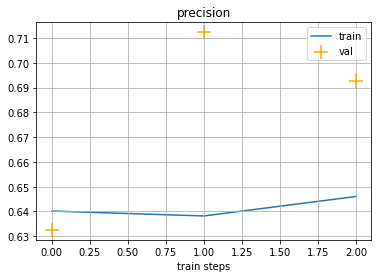

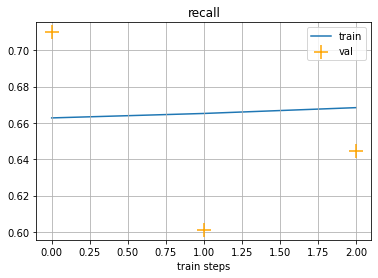

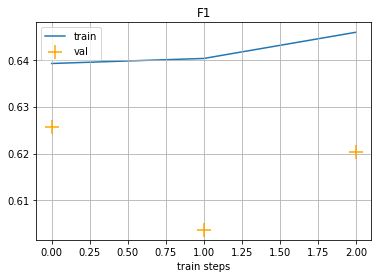

0it [00:00, ?it/s]

In [ ]:
trainer = UnetTrainer(model, optimizer, criterion, device, metric_functions=make_metrics(), epoch_number=13)
summary = trainer.fit(
    train_loader, num_epochs=20,
    folder_to_save=folder_to_save,
    val_loader=val_loader, update_every_n_batches = 4 // batch_size  # a * b = 4
)

Epoch: 42



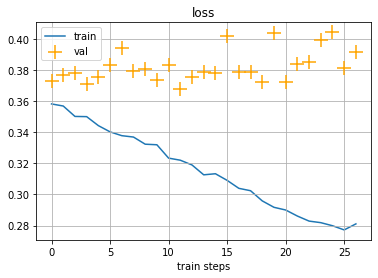

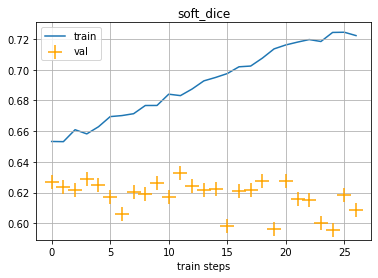

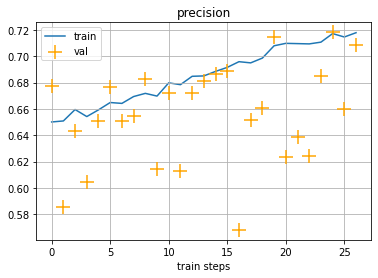

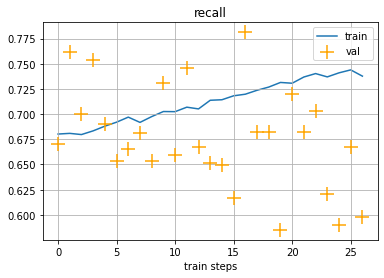

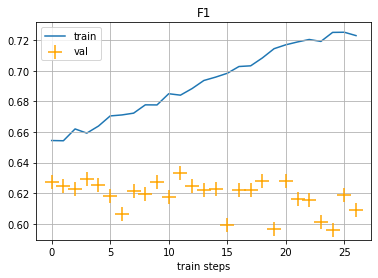

0it [00:00, ?it/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5 * 1e-4)

trainer = UnetTrainer(model, optimizer, criterion, device, metric_functions=make_metrics(), epoch_number=16)
summary = trainer.fit(
    train_loader, num_epochs=50,
    folder_to_save=folder_to_save,
    val_loader=val_loader, update_every_n_batches = 4 // batch_size  # a * b = 4
)

In [ ]:
epoch_num = 41 - 16

print(f"Val F1 - {summary['F1_val'][epoch_num]:.3f}")
print(f"Train F1 - {summary['F1_train'][epoch_num]:.3f}")

Val F1 - 0.619
Train F1 - 0.725


**Baseline:**
* Unet
* resnet50
* batchsize = 4
* img_size = (1024, 1024)
* epochs = 10

| Model              | Train F1    | Val F1    | Liderboard F1    |
|--------------------|-------------|-----------|------------------|
| Baseline (UPD.)    | 0.601       | 0.602     | 0.541 (!)        |
| 512x512            | 0.628       | 0.570     | 0.443            |
| 1632x1632          | 0.616       | 0.587     | 0.550 (!)        |
| pad to 1632x1632   | ~0.620      | 0.595     | 0.559 (!)        |
| EfficientNetV0     | 0.635       | 0.580     | 0.557 (fast)     |
| Flips (aug)        | 0.608       | 0.568     | 0.546            |
| BS=16, lr=1e-3     | 0.636       | 0.611     | 0.552            |
| IoU loss           | 0.610       | 0.601     | 0.544            |
| Grayscale          | 0.623       | 0.594     | 0.551            |
| tu-mixnet_m        | 0.618       | 0.589     | 0.550            |
| 97.5% - train part (epoch 5) | 0.632       | 0.613     | 0.561 (!)        |
| HorizontalFlip     | 0.620       | 0.608     | 0.565 (!)            |
| DeepLabV3Plus, resnet50 | 0.617  | 0.597     | 0.557            |
| The best (epoch 4) | ~0.615      | ~0.614    | 0.567            |
| The best (epoch 7) | 0.627       | 0.625     | 0.564            |
| The best (epoch 9) |        |      |             |
| The best (epoch 11)|        |      |             |
| The best (epoch 12)| 0.638       | 0.634     | 0.575            |
| The best (epoch 15)| 0.646       | 0.620     | 0.574            |
| The best (epoch 20)| 0.664       | 0.626     | 0.572            |
| The best (epoch 27)| 0.684       | 0.633     | 0.571            |
| The best (epoch 32)| 0.703       | 0.622     |             |
| The best (epoch 37)| 0.719       | 0.616     |             |
| The best (epoch 42)| 0.723       | 0.609     |             |
| The best (epoch )|        |      |             |

In [ ]:
epoch_num = 11  # use this epoch for get predictions

model_path = os.path.join(folder_to_save, f'epoch_{epoch_num}.pth')
model = smp.Unet('vgg16', activation='logsoftmax', classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval();

In [ ]:
trainer = UnetTrainer(model, optimizer, criterion, device, metric_functions=make_metrics())
trainer.evaluate(val_loader, eval_on_n_batches=1)

0it [00:00, ?it/s]

{'loss': 0.4033467278761022,
 'soft_dice': 0.5966532861485201,
 'precision': 0.598564879859195,
 'recall': 0.6772207793067483,
 'jacc': 0.4362164227401509,
 'F1': 0.608173174016616}

In [ ]:
THRESHOLD = 0.5
THRESHOLD

0.5

## Посмотрим работу обученной модели на валидационном датасете

           Исходное изображение                           Предсказания модели                           Эталонная разметка

 216.png


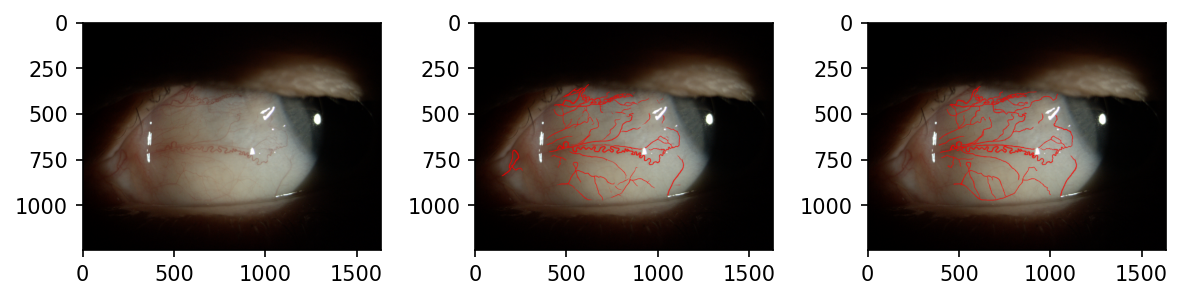


 345.png


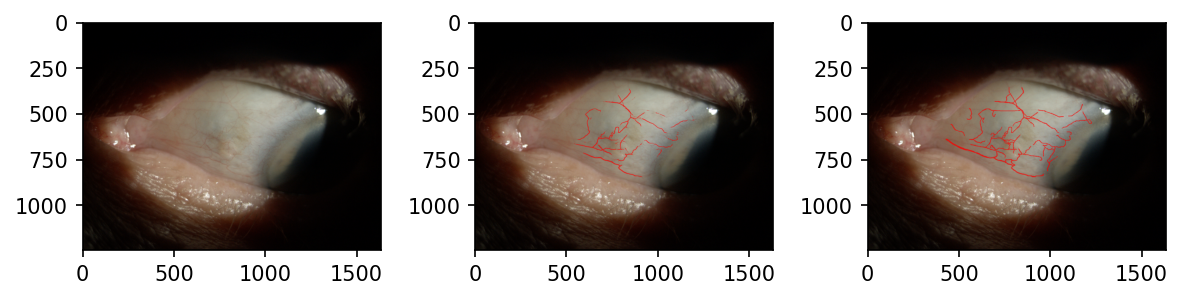


 643.png


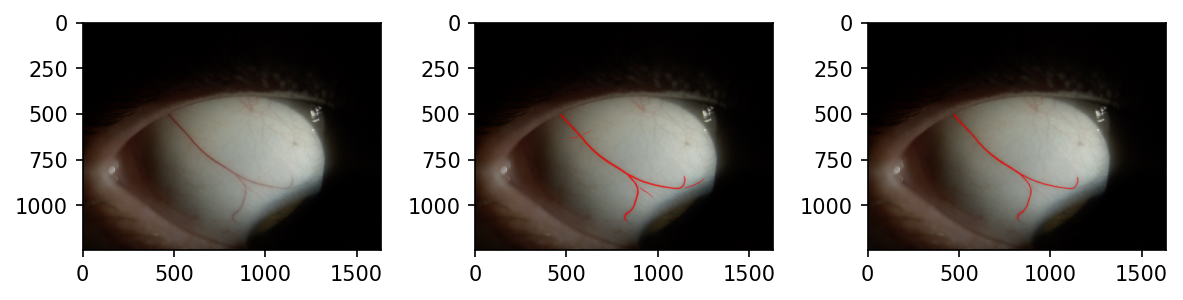

In [ ]:
# Посмотрим на картинки предсказаний
begin_ind = 0
end_ind = 3

model.eval()

print(f'{" " * 10} Исходное изображение {" " * 25} Предсказания модели {" " * 25} Эталонная разметка')

for i, sample in zip(range(begin_ind, end_ind), val_dataset):
    fig, axs = plt.subplots(1, 3, figsize=(8, 8), dpi=150)

    print('\n', sample['img_name'])

    image = sample['image'].to(device)
    true_mask = sample['mask'].to(device)

    with torch.no_grad():
        prediction = model(image.unsqueeze(dim=0)).cpu()

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > THRESHOLD)

    axs[0].imshow(np.moveaxis(image.cpu().numpy(), 0, -1))
    # axs[0].axis('off')

    image_with_mask = draw_segmentation_masks(image, ~pred_ask, colors='red')
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[1].imshow(image_with_mask)
    # axs[1].axis('off')

    image_with_mask = draw_segmentation_masks(image, ~true_mask.type(torch.bool), colors='red')
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[2].imshow(image_with_mask)
    # axs[2].axis('off')

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

## Предсказание на тестовых данных

In [ ]:
test_dataset = EyeDataset("eye_test", transform=transforms['test'], train=False)

Total images: 301


In [ ]:
def make_predictions(dataset, folder):
    model.eval()

    if not os.path.exists(folder):
        os.mkdir(folder)
    
    PRED_SIZE = (1232, 1624)

    for i, sample in enumerate(tqdm(dataset)):
        image = sample['image']
        img_name = sample['img_name']
        
        with torch.no_grad():
            prediction = model(image.to(device).unsqueeze(dim=0)).cpu()
        
        mask = torch.exp(prediction[0, 1:])

        image = torch.permute(image, (1, 2, 0)).numpy().astype(np.uint8)
        mask = torch.permute(mask, (1, 2, 0)).numpy().astype(float)

        pad_size_0 = (mask.shape[0] - PRED_SIZE[0]) // 2
        pad_size_1 = (mask.shape[1] - PRED_SIZE[1]) // 2
        mask = mask[pad_size_0: -pad_size_0, pad_size_1: -pad_size_1, 0]

        mask = mask > THRESHOLD
        mask = (mask[..., None] * 255).astype(np.uint8)

        cv2.imwrite(os.path.join(folder, img_name), mask)

In [ ]:
solution_name = 'solution'
folder = solution_name

make_predictions(test_dataset, folder)
shutil.make_archive(solution_name, 'zip', folder)

  0%|          | 0/301 [00:00<?, ?it/s]

'/kaggle/working/solution.zip'

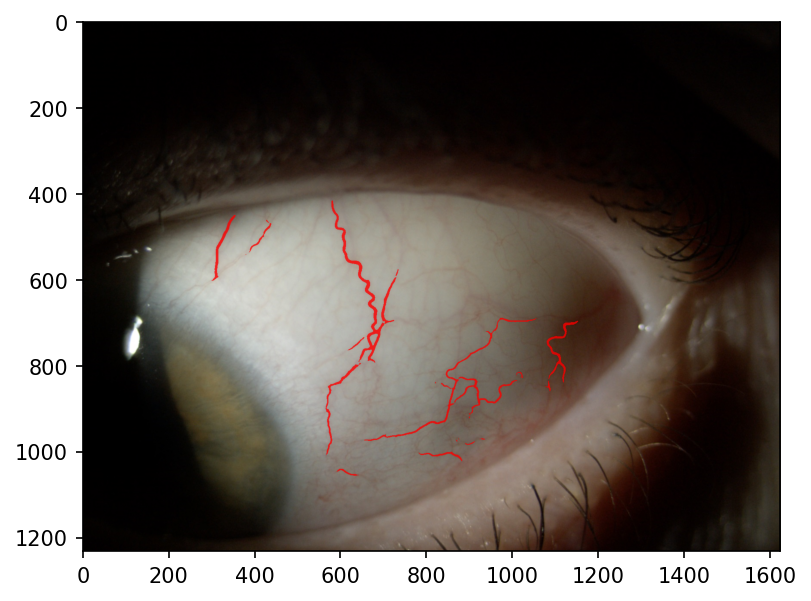

In [ ]:
folder = solution_name


for i, img_name in zip(range(1), os.listdir(folder)):
    image = cv2.imread(os.path.join('eye_test', img_name), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(folder, img_name))

    image = np.moveaxis(image, 2, 0)
    image = torch.tensor(image)

    mask = np.moveaxis(mask, 2, 0)
    mask = torch.tensor(mask)
    mask = (mask / 255).type(torch.bool)

    image_with_mask = draw_segmentation_masks(image, mask, colors='red')
    image_with_mask = np.moveaxis(image_with_mask.numpy(), 0, -1)

    plt.figure(figsize=(6, 6), dpi=150)
    plt.imshow(image_with_mask)
    plt.show()